In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np

In [28]:
X, y = make_blobs(n_samples=1500, n_features=2, centers=5, cluster_std=1.0, random_state=42)

In [29]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =42, test_size=0.2)

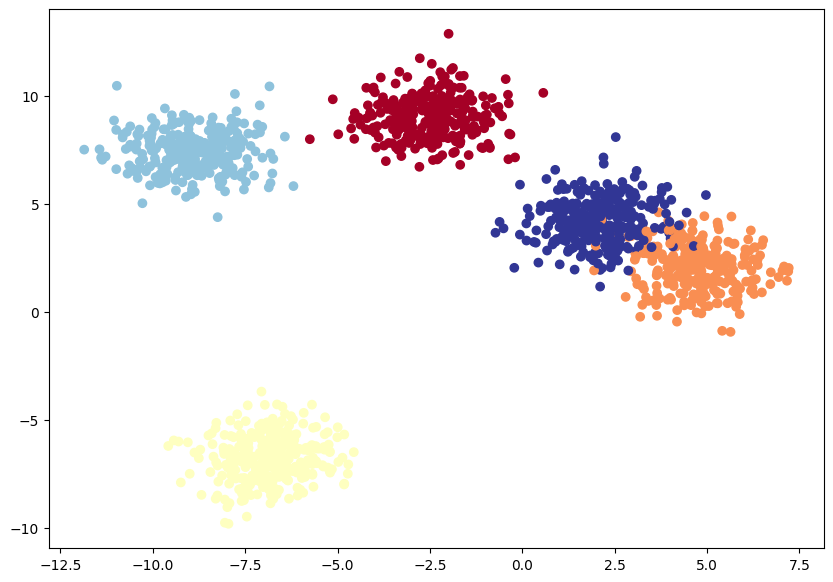

In [31]:
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [32]:
import torch.nn as nn

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=15):
    super().__init__()
    self.linear_layer = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer(x)

model = BlobModel(input_features = 2, output_features=5, hidden_units=10)
model

BlobModel(
  (linear_layer): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=5, bias=True)
  )
)

In [33]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params = model.parameters(), lr = 0.1)

In [34]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [35]:
torch.manual_seed(42)

for epoch in range(100):
  model.train()
  y_logits = model(X_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss_ = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  opt.zero_grad()
  loss_.backward()
  opt.step()

  model.eval()
  with torch.inference_mode():
    y_logits_test = model(X_test)
    y_preds_test = torch.softmax(y_logits_test, dim=1).argmax(dim=1)
    loss_test = loss_fn(y_logits_test, y_test)
    acc_test = accuracy_fn(y_true=y_test, y_pred=y_preds_test)


  if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss_:.5f}, Acc: {acc:.2f}% | Test Loss: {loss_test:.5f}, Test Acc: {acc_test:.2f}%")

Epoch: 0 | Loss: 1.60208, Acc: 20.25% | Test Loss: 1.58528, Test Acc: 27.00%
Epoch: 10 | Loss: 1.42241, Acc: 44.83% | Test Loss: 1.39594, Test Acc: 55.00%
Epoch: 20 | Loss: 1.12742, Acc: 56.75% | Test Loss: 1.11525, Test Acc: 55.00%
Epoch: 30 | Loss: 0.88508, Acc: 65.92% | Test Loss: 0.87665, Test Acc: 67.33%
Epoch: 40 | Loss: 0.58014, Acc: 77.83% | Test Loss: 0.59041, Test Acc: 94.00%
Epoch: 50 | Loss: 0.43708, Acc: 95.58% | Test Loss: 0.48447, Test Acc: 95.00%
Epoch: 60 | Loss: 0.36628, Acc: 97.67% | Test Loss: 0.39471, Test Acc: 98.67%
Epoch: 70 | Loss: 0.29739, Acc: 97.58% | Test Loss: 0.32839, Test Acc: 98.67%
Epoch: 80 | Loss: 0.25749, Acc: 97.50% | Test Loss: 0.28637, Test Acc: 98.67%
Epoch: 90 | Loss: 0.22781, Acc: 97.50% | Test Loss: 0.25365, Test Acc: 98.67%


In [36]:
model.eval()
with torch.inference_mode():
    y_logits_test = model(X_test)
y_logits_test[:5]

tensor([[  4.8968, -10.1487,  -5.9121,   3.4333,   0.1203],
        [ -2.2167,  -0.6648,  -2.5944,  -6.8308,   3.6842],
        [ -0.2942,  -2.8011,  -2.7098,  -4.7316,   2.8709],
        [  2.6033,  -7.6980,  -2.6547,   7.5439,  -1.6084],
        [  5.5015, -10.6197,  -6.7918,   1.8130,   0.7436]])

In [37]:
y_preds_prob = torch.softmax(y_logits_test, dim=1)
y_preds = y_preds_prob.argmax(dim=1)

print(f"Predictions: {y_preds[:5]}\nLabels: {y_test[:5]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_test, y_pred=y_preds)}%")

Predictions: tensor([0, 4, 4, 3, 0])
Labels: tensor([0, 4, 4, 3, 0])
Test accuracy: 98.66666666666667%


In [38]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

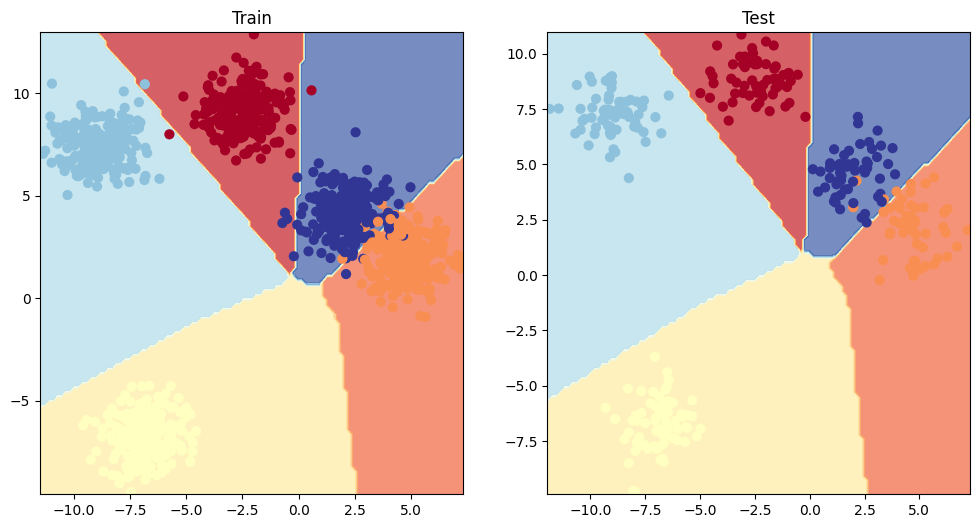

In [39]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

Model Summary:
- Number of Classes: 5
- Neural Network Architecture:
  - Input Layer: 2
  - Hidden Layers: Two layers, each with 10 neurons and ReLu activation function due to non linearity
  - Output Layer: 5 neurons with softmax activation.
- Loss Function: Crossentropy (due to multiclass labels)
- Optimizer: Stochastic Gradient Descent (SGD)
- Accuracy: 98%